# EfficientNet+Augmentation for Cassava Disease Classification using TF.Keras

This notebook presents a full pipeline to load the data, apply advanced data augmentation, train an EfficientNet and use the model to predict over the test images. To make it possible to run within the allocated time for notebooks, this notebook will only present a single fold with a split of 80% for training and 20% for validation. Due to the original image size of 600x800 pixels, we will randomly crop 512x512 images from original images in order to keep the highest image resolution possible for our model training. Previous versions of this notebook used resized images and the results were extremely poor in comparison (~0.42 accuracy).

Below are some version notes which were written at version 20 so I only included what I could remember.

Version notes:
* 27: Fix bug in the TTA process.
* 26: Move from using `ImageDataGenerator` to `tf.data` to load data into the model. This allows to tune the Normalization layer in the pretrained EfficientNetB3 model provided by `tf.keras`. By default, images are normalized using the `imagenet` dataset's mean and standard deviation. *- score: 0.888*
* 24: Test CosineDecay instead of ReduceLRonPlateau and increase the dropout rate within the EfficientNetB3 model. *- score: 0.885*
* 22: Replace the custom generator and data augmentation using `imgaug` with the new Keras preprocessing layers. Also increase the image size from 300x300 to 512x512. *- score: 0.880*
* 21: *- score: 0.883*
* 20: Fix bug activating the "training mode" by default in the custom generator, even during validation. Removed data standardization and class weights, simplify the bottleneck layers of the model, and remove the dropout from the data augmentation techniques. *- score: 0.873*
* 17: Additional data augmentation techniques. *- score: 0.821*
* 16: Tighter scan of the images at test time. *- score: 0.857*
* 15: Add data standardization. (Cannot remember if there was a bug but the score was abnormaly low) *- score: 0.692*
* 11: Train the model by randomly cropping 300x300pixel tiles from the original images *- score: 0.847*
* 9: Classification from resized images. *- score: 0.421* 

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.preprocessing import minmax_scale
import random
import cv2
from imgaug import augmenters as iaa
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop,CenterCrop, RandomRotation

C:\Users\wangz\anaconda3\envs\tf_gpu23-2\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
training_folder = '../input/cassava-leaf-disease-classification/train_images/'

In [4]:
samples_df = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
samples_df = shuffle(samples_df, random_state=42)
samples_df["filepath"] = training_folder+samples_df["image_id"]

In [5]:
training_percentage = 0.8
training_item_count = int(len(samples_df)*training_percentage)
validation_item_count = len(samples_df)-int(len(samples_df)*training_percentage)
training_df = samples_df[:training_item_count]
validation_df = samples_df[training_item_count:]

In [6]:
batch_size = 4
image_size = 512
input_shape = (image_size, image_size, 3)
dropout_rate = 0.4
classes_to_predict = sorted(training_df.label.unique())
n_ouput = len(classes_to_predict)

In [7]:
training_data = tf.data.Dataset.from_tensor_slices((training_df.filepath.values, training_df.label.values))
validation_data = tf.data.Dataset.from_tensor_slices((validation_df.filepath.values, validation_df.label.values))

In [8]:
def load_image_and_label_from_path(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img, label

AUTOTUNE = tf.data.experimental.AUTOTUNE

training_data = training_data.map(load_image_and_label_from_path, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(load_image_and_label_from_path, num_parallel_calls=AUTOTUNE)

In [9]:
training_data_batches = training_data.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
validation_data_batches = validation_data.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [10]:
adapt_data = tf.data.Dataset.from_tensor_slices(training_df.filepath.values)
def adapt_mode(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = layers.experimental.preprocessing.Rescaling(1.0 / 255)(img)
    return img

adapt_data = adapt_data.map(adapt_mode, num_parallel_calls=AUTOTUNE)
adapt_data_batches = adapt_data.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [11]:
data_augmentation_layers = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomCrop(height=image_size, width=image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.25),
        layers.experimental.preprocessing.RandomZoom((-0.2, 0)),
        layers.experimental.preprocessing.RandomContrast((0.2,0.2))
    ]
)

In [12]:
efficientnet = EfficientNetB3(#weights='../model/efficientnet-b3_noisy-student.h5', 
                              include_top=False, 
                              input_shape=input_shape, 
                              drop_connect_rate=dropout_rate)

inputs = Input(shape=input_shape)
augmented = data_augmentation_layers(inputs)
efficientnet = efficientnet(augmented)
pooling = layers.GlobalAveragePooling2D()(efficientnet)
dropout = layers.Dropout(dropout_rate)(pooling)
outputs = Dense(n_ouput, activation="softmax")(dropout)
model = Model(inputs=inputs, outputs=outputs)
    
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 16, 16, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 7685      
Total params: 10,791,220
Trainable params: 10,703,917
Non-trainable params: 87,303
_____________________________________

In [13]:
%%time
model.get_layer('efficientnetb3').get_layer('normalization').adapt(adapt_data_batches)

Wall time: 8min 4s


In [14]:
epochs = 8
decay_steps = int(round(len(training_df)/batch_size))*epochs
cosine_decay = CosineDecay(initial_learning_rate=1e-4, decay_steps=decay_steps, alpha=0.3)

callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(cosine_decay), metrics=["accuracy"])

In [15]:
history = model.fit(training_data_batches,
                  epochs = epochs, 
                  validation_data=validation_data_batches,
                  callbacks=callbacks)

Epoch 1/8
4280/4280 [==============================] - 1015s 237ms/step - loss: 0.6378 - accuracy: 0.7794 - val_loss: 0.4713 - val_accuracy: 0.8285
Epoch 2/8
4280/4280 [==============================] - 1004s 235ms/step - loss: 0.4902 - accuracy: 0.8359 - val_loss: 0.4818 - val_accuracy: 0.8311
Epoch 3/8
4280/4280 [==============================] - 1018s 238ms/step - loss: 0.4390 - accuracy: 0.8505 - val_loss: 0.4388 - val_accuracy: 0.8474
Epoch 4/8
4280/4280 [==============================] - 1013s 237ms/step - loss: 0.3962 - accuracy: 0.8683 - val_loss: 0.4027 - val_accuracy: 0.8689
Epoch 5/8
4280/4280 [==============================] - 1009s 236ms/step - loss: 0.3763 - accuracy: 0.8753 - val_loss: 0.4537 - val_accuracy: 0.8456
Epoch 6/8
4280/4280 [==============================] - 1018s 238ms/step - loss: 0.3527 - accuracy: 0.8819 - val_loss: 0.3989 - val_accuracy: 0.8661
Epoch 7/8
4280/4280 [==============================] - 1011s 236ms/step - loss: 0.3319 - accuracy: 0.8884 - val_

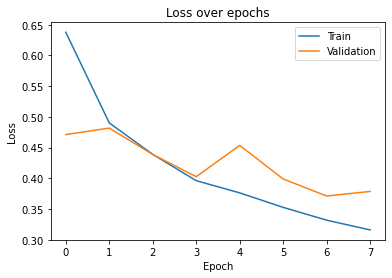

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

# Prediction on test images

In [3]:
model.load_weights("best_model.h5")

NameError: name 'model' is not defined

In [19]:
def scan_over_image(img_path, crop_size=512):
    '''
    Will extract 512x512 images covering the whole original image
    with some overlap between images
    '''
    
    img = Image.open(img_path)
    img_height, img_width = img.size
    img = np.array(img)
    
    y = random.randint(0,img_height-crop_size)
    x = random.randint(0,img_width-crop_size)

    x_img_origins = [0,img_width-crop_size]
    y_img_origins = [0,img_height-crop_size]
    img_list = []
    for x in x_img_origins:
        for y in y_img_origins:
            img_list.append(img[x:x+crop_size , y:y+crop_size,:])
  
    return np.array(img_list)

In [21]:
# def display_samples(img_path):
#     '''
#     Display all 512x512 images extracted from original images
#     '''
    
#     img_list = scan_over_image(img_path)
#     sample_number = len(img_list)
#     fig = plt.figure(figsize = (8,sample_number))
#     for i in range(0,sample_number):
#         ax = fig.add_subplot(2, 4, i+1)
#         ax.imshow(img_list[i])
#         ax.set_title(str(i))
#     plt.tight_layout()
#     plt.show()

# display_samples("../input/cassava-leaf-disease-classification/train_images/3412658650.jpg")

In [22]:
test_time_augmentation_layers = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomZoom((-0.2, 0)),
        layers.experimental.preprocessing.RandomContrast((0.2,0.2))
    ]
)

In [23]:
def predict_and_vote(image_filename, folder, TTA_runs=4):
    '''
    Run the model over 4 local areas of the given image,
    before making a decision depending on the most predicted
    disease.
    '''
    
    #apply TTA to each of the 4 images and sum all predictions for each local image
    localised_predictions = []
    local_image_list = scan_over_image(folder+image_filename)
    for local_image in local_image_list:
        duplicated_local_image = tf.convert_to_tensor(np.array([local_image for i in range(TTA_runs)]))
        augmented_images = test_time_augmentation_layers(duplicated_local_image)
        
        predictions = model.predict(augmented_images)
        localised_predictions.append(np.sum(predictions, axis=0))
    
    #sum all predictions from all 4 images and retrieve the index of the highest value
    global_predictions = np.sum(np.array(localised_predictions),axis=0)
    final_prediction = np.argmax(global_predictions)
    
    return final_prediction

In [24]:
def run_predictions_over_image_list(image_list, folder):
    predictions = []
    with tqdm(total=len(image_list)) as pbar:
        for image_filename in image_list:
            pbar.update(1)
            predictions.append(predict_and_vote(image_filename, folder))
    return predictions

In [29]:
validation_df["results"] = run_predictions_over_image_list(validation_df["image_id"], training_folder)

100%|██████████| 4280/4280 [17:48<00:00,  4.01it/s]


In [30]:
validation_df.head()

,image_id,label,filepath,results
10234,2824543301.jpg,3,../input/cassava-leaf-disease-classification/t...,3
4763,184909120.jpg,3,../input/cassava-leaf-disease-classification/t...,3
9062,2602456265.jpg,3,../input/cassava-leaf-disease-classification/t...,3
1874,1331491784.jpg,3,../input/cassava-leaf-disease-classification/t...,3
17431,414363375.jpg,3,../input/cassava-leaf-disease-classification/t...,3


In [31]:
true_positives = 0
prediction_distribution_per_class = {"0":{"0": 0, "1": 0, "2":0, "3":0, "4":0},
                                     "1":{"0": 0, "1": 0, "2":0, "3":0, "4":0},
                                     "2":{"0": 0, "1": 0, "2":0, "3":0, "4":0},
                                     "3":{"0": 0, "1": 0, "2":0, "3":0, "4":0},
                                     "4":{"0": 0, "1": 0, "2":0, "3":0, "4":0}}
number_of_images = len(validation_df)
for idx, pred in validation_df.iterrows():
    if int(pred["label"]) == pred.results:
        true_positives+=1
    prediction_distribution_per_class[str(pred["label"])][str(pred.results)] += 1
print("accuracy: {}%".format(true_positives/number_of_images*100))

accuracy: 88.41121495327103%


In [32]:
test_folder = '../input/cassava-leaf-disease-classification/test_images/'
submission_df = pd.DataFrame(columns={"image_id","label"})
submission_df["image_id"] =  os.listdir(test_folder)
submission_df["label"] = 0

In [33]:
submission_df["label"] = run_predictions_over_image_list(submission_df["image_id"], test_folder)

100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


In [34]:
submission_df.to_csv("submission.csv", index=False)